In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
import catboost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
import optuna
import warnings
warnings.filterwarnings('ignore')

In [3]:
# cargamos el dataset
bdif = pd.read_excel("bdif_modelo_2017.xlsx")
bdif.head()

,parte,año,cod_com,cod_prov,probignicion,detectadopor,fecha,combustible,fuego,lugar,...,velmedia,racha,sol,hrmedia,fwi,denpoblacion,denincendios,horario,areaquemada,claseincendio
0,1974020249,1974,11,2,0.0,otros,1974-04-25,bosques,sup_cop,otros,...,6.1,11.900000,9.5,56.0,12.101361,0.041339,0.000020,Tarde,8.0,incendio
1,1974020374,1974,11,2,0.0,otros,1974-05-19,bosques,sup_cop,excursionistas,...,6.4,13.100000,10.9,53.0,69.039001,0.334612,0.000013,Tarde,0.3,conato
2,1974020459,1974,11,46,0.0,agente_forestal,1974-06-11,bosques,sup_cop,otros,...,3.6,11.100000,3.3,71.0,11.837668,0.084859,0.000022,Mañana,0.6,conato
3,1974022274,1974,11,2,0.0,otros,1974-09-11,bosques,sup_cop,autovia_carretera,...,5.0,7.116667,8.9,63.0,42.358257,0.139880,0.000123,Tarde,2.0,incendio
4,1974022457,1974,11,2,0.0,agente_forestal,1974-10-01,mat_bos,sup_cop,otros,...,4.7,14.400000,9.3,45.0,15.454229,0.035034,0.000068,Mañana,0.5,conato


In [4]:
# para poder recuperarlo
bdif_save = bdif.copy()

### Aplicamos el mapeo de clases para la variable objetivo

In [5]:
# Crear un diccionario para mapear las clases a valores específicos
mapeo_clases = {'conato': 0, 'incendio': 1, 'gif': 2}

# Aplicar el mapeo a la columna 'claseincendio'
bdif['claseincendio'] = bdif['claseincendio'].map(mapeo_clases)

# Verificar el resultado
bdif['claseincendio'].value_counts()

claseincendio
0    339190
1    237218
2      2008
Name: count, dtype: int64

In [6]:
# Separamos el dataset para usarlo para el entrenamiento del modelo
bdif_modelo = bdif[bdif['año'] <= 2016]
bdif_modelo.shape

(570372, 30)

### Preprocesamiento de los datos

In [7]:
# Seleccionamos las variables numéricas y categóricas 
numericas = ['probignicion', 'altitud', 'lon', 'lat', 'prec', 'tmax', 'dir', 'velmedia',
             'racha', 'sol', 'hrmedia', 'denpoblacion', 'denincendios', 'fwi']
categoricas = ['detectadopor', 'combustible', 'fuego', 'lugar', 'mes', 'dia', 'horario']

# Aplicamos las transformaciones para cada tipo de variable
prep = ColumnTransformer(transformers=[
        ('num', MinMaxScaler(), numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop=None, sparse_output=False), categoricas),])

# Creamos el pipeline
pipeline = Pipeline(steps=[('prep', prep)])

# Introducimos los datos de entrada
X = bdif_modelo.drop(columns=['claseincendio'])

# Ajustar el Pipeline a los datos y transformar
X_prep = pipeline.fit_transform(X)

# Lo pasamos a dataframe
X_prepdf = pd.DataFrame(X_prep, columns=pipeline.named_steps['prep'].get_feature_names_out())

# Hay que convertir las columnas categoricas a enteros
dummies = X_prepdf.filter(regex='^cat').columns
X_prepdf[dummies] = X_prepdf[dummies].astype(int)

# Eliminamos los prefijos
X_prepdf.columns = X_prepdf.columns.str.replace(r'^(num__|cat__)', '', regex=True)

# Reconstruimos el dataset y lo mostramos
X_prepdf['claseincendio'] = bdif_modelo['claseincendio']
bdif_reconstruido = X_prepdf.copy()
bdif_reconstruido.head()

,probignicion,altitud,lon,lat,prec,tmax,dir,velmedia,racha,sol,...,mes_septiembre,dia_festivo,dia_lab_vis_fes,dia_laborable,dia_sabado,horario_Madrugada,horario_Mañana,horario_Noche,horario_Tarde,claseincendio
0,0.0,0.517710,0.703490,0.663822,0.0,0.462795,0.805556,0.194268,0.218750,0.637584,...,0,0,0,1,0,0,0,0,1,1
1,0.0,0.335891,0.731106,0.672918,0.0,0.637024,0.500000,0.203822,0.240809,0.731544,...,0,1,0,0,0,0,0,0,1,0
2,0.0,0.351240,0.760152,0.707177,0.0,0.571688,0.250000,0.114650,0.204044,0.221477,...,0,0,0,1,0,0,1,0,0,0
3,0.0,0.664109,0.699029,0.672143,0.0,0.662432,0.418981,0.159236,0.130821,0.597315,...,1,0,0,1,0,0,0,0,1,1
4,0.0,0.410272,0.714636,0.675420,0.0,0.575318,0.694444,0.149682,0.264706,0.624161,...,0,0,0,1,0,0,1,0,0,0


In [8]:
# Tomamos el dataset con las caracteristicas que nos interesan
bdif_reconstruido = bdif_reconstruido[['denincendios', 'tmax', 'denpoblacion', 'lon', 'lat', 'fuego_sup_cop', 'fwi', 'hrmedia', 'altitud',
          'fuego_superficie', 'sol', 'racha', 'dir', 'velmedia', 'probignicion', 'combustible_matorrales',
          'combustible_mat_bos', 'prec', 'combustible_pas_mat_bos', 'detectadopor_agente_forestal', 'horario_Noche',
          'horario_Tarde', 'lugar_otros', 'detectadopor_vigilante_fijo', 'dia_laborable', 'mes_agosto',
          'detectadopor_llamada_particular', 'lugar_autovia_carretera', 'lugar_senda', 'detectadopor_otros', 'dia_festivo',
          'mes_septiembre', 'combustible_pastizales', 'dia_sabado', 'combustible_bosques', 'horario_Mañana', 'claseincendio']]
bdif_reconstruido.head()

,denincendios,tmax,denpoblacion,lon,lat,fuego_sup_cop,fwi,hrmedia,altitud,fuego_superficie,...,lugar_autovia_carretera,lugar_senda,detectadopor_otros,dia_festivo,mes_septiembre,combustible_pastizales,dia_sabado,combustible_bosques,horario_Mañana,claseincendio
0,0.000014,0.462795,0.000166,0.703490,0.663822,1,0.068724,0.541667,0.517710,0,...,0,0,1,0,0,0,0,1,0,1
1,0.000006,0.637024,0.001347,0.731106,0.672918,1,0.421203,0.510417,0.335891,0,...,0,0,1,1,0,0,0,1,0,0
2,0.000018,0.571688,0.000341,0.760152,0.707177,1,0.067092,0.697917,0.351240,0,...,0,0,0,0,0,0,0,1,1,0
3,0.000145,0.662432,0.000563,0.699029,0.672143,1,0.256033,0.614583,0.664109,0,...,1,0,1,0,1,0,0,1,0,1
4,0.000076,0.575318,0.000141,0.714636,0.675420,1,0.089480,0.427083,0.410272,0,...,0,0,0,0,0,0,0,0,1,0


### CatBoost con el dataset completo

In [9]:
# Separamos variables descriptivas de 
X = bdif.drop(['claseincendio'], axis=1)
y = bdif['claseincendio']

### CarBoost con el dataset submuestreado con ENN + Tomek Links

In [10]:
bdif_enn_tomek = pd.read_excel("bdif_submuestreado.xlsx")
bdif_enn_tomek.head()

,denincendios,tmax,denpoblacion,lon,lat,fuego_sup_cop,fwi,hrmedia,altitud,fuego_superficie,...,lugar_autovia_carretera,lugar_senda,detectadopor_otros,dia_festivo,mes_septiembre,combustible_pastizales,dia_sabado,combustible_bosques,horario_Mañana,claseincendio
0,0.014306,0.618875,0.000183,0.559100,0.802846,0,0.265486,0.572917,0.543093,1,...,0,0,0,0,0,1,0,0,0,0
1,0.000358,0.542650,0.000068,0.523174,0.647512,0,0.000000,0.656250,0.418536,1,...,0,1,1,0,0,1,1,0,0,0
2,0.000269,0.802178,0.000060,0.574670,0.718691,0,0.378725,0.427083,0.236128,1,...,0,0,0,0,0,0,0,0,0,0
3,0.000112,0.802178,0.000010,0.587270,0.722982,0,0.378725,0.427083,0.257379,1,...,0,0,0,0,0,0,0,0,0,0
4,0.000112,0.802178,0.000010,0.587270,0.722982,0,0.378725,0.427083,0.257379,1,...,0,0,0,0,0,0,0,0,0,0


In [11]:
print(bdif_enn_tomek['claseincendio'].value_counts())

claseincendio
0    70482
1    26177
2     1966
Name: count, dtype: int64


In [12]:
bdif_save = bdif_enn_tomek.copy()

In [13]:
#bdif_enn_tomek = bdif_save.copy()

### Dataset submuestreado de clases mayoritarias y reducido aleatoriamente a la clase minoritaria

En este caso reducimos el número de muestras de las clases mayoritarias, conatos e incendios. Aunque estan siendo muy bien identificadas, el hecho de que tengamos tantas muestras en favor de esas clases, hace que la clase más importante no esté siendo clasificada, por ello, trataremos de balancear el dataset. 

Reducimos aleatoriamente las muestras de las clases conatos e incendios a un número fijo de muestras.

In [12]:
X = bdif_enn_tomek.drop(['claseincendio'], axis=1)
y = bdif_enn_tomek['claseincendio']

# Submuestreo aleatorio {0: int(2*y.value_counts()[2]), 1: int(1.5*y.value_counts()[2])}
rus = RandomUnderSampler(sampling_strategy={0:int(0.12*y.value_counts()[1]), 1:int(0.12*y.value_counts()[1])}, random_state=42)
X_res, y_res = rus.fit_resample(X, y)

bdif_sub = pd.concat([X_res, y_res], axis=1)
print(bdif_sub['claseincendio'].value_counts())

claseincendio
0    3141
1    3141
2    1966
Name: count, dtype: int64


Realizamos el sobremuestreo del gif con RandomOverSampler para balancear el dataset y tratar de acercarnos al número de muestras de las clases mayoritarias. El sobremuestreo lo realizamos sólo en el entrenamiento, el conjunto de test se deja intacto.

### Incrementamos la clase gif con RandomOverSampler

In [13]:
X = bdif_sub.drop(['claseincendio'], axis=1)
y = bdif_sub['claseincendio']

X_train_sob, X_test, y_train_sob, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

random_oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train, y_train = random_oversampler.fit_resample(X_train_sob, y_train_sob)

print(f"Distribución de clases en el conjunto de entrenamiento después de Random Over-Sampling: {Counter(y_train)}")
print(f"Distribución de clases en el conjunto de test: {Counter(y_test)}")

Distribución de clases en el conjunto de entrenamiento después de Random Over-Sampling: Counter({1: 2513, 0: 2513, 2: 2513})
Distribución de clases en el conjunto de test: Counter({0: 629, 1: 628, 2: 393})


### Bloque cálculos

In [14]:
# Crear el modelo
model = CatBoostClassifier(
    iterations = 500,
    learning_rate = 0.1,
    depth = 5,
    verbose = 100
)
# Entrenar el modelo
model.fit(X_train, y_train)

# Predecir
y_pred = model.predict(X_test)

0:	learn: 1.0304645	total: 173ms	remaining: 1m 26s
100:	learn: 0.4215237	total: 573ms	remaining: 2.26s
200:	learn: 0.3472071	total: 910ms	remaining: 1.35s
300:	learn: 0.3031015	total: 1.24s	remaining: 821ms
400:	learn: 0.2695550	total: 1.59s	remaining: 393ms
499:	learn: 0.2423169	total: 1.94s	remaining: 0us


In [15]:
# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 85.33%


In [16]:
# Predicciones
y_pred_proba = model.predict_proba(X_test)
# Mostrar el reporte de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       629
           1       0.86      0.79      0.83       628
           2       0.71      0.81      0.76       393

    accuracy                           0.85      1650
   macro avg       0.84      0.85      0.84      1650
weighted avg       0.86      0.85      0.85      1650



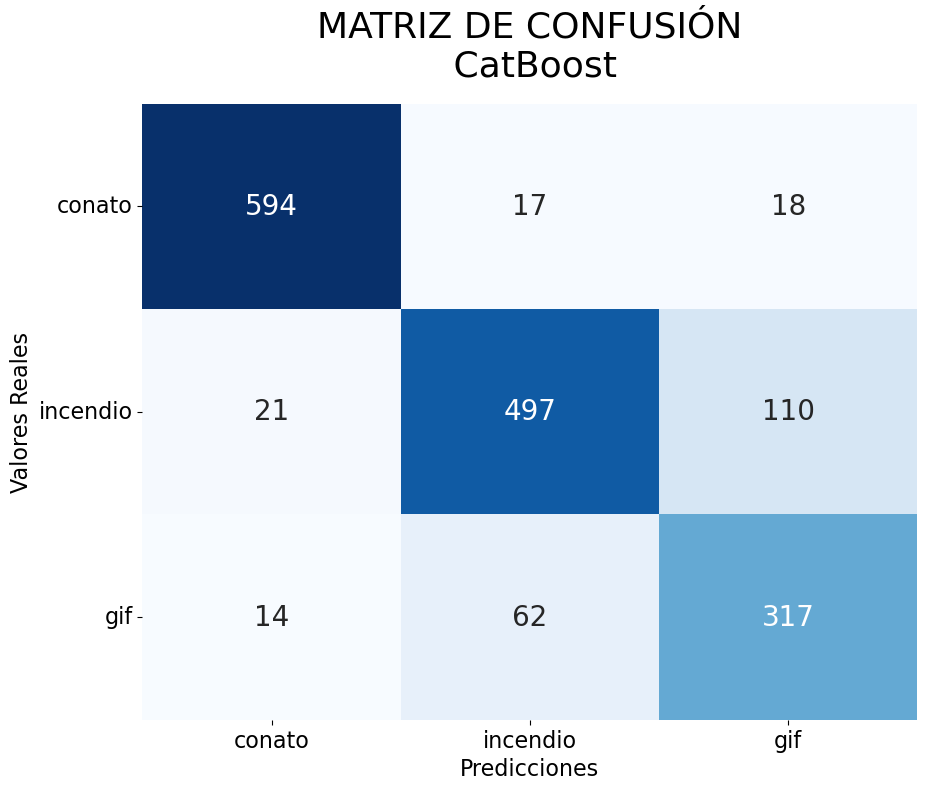

In [18]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Etiquetas de las clases
etiquetas = ['conato', 'incendio', 'gif']

plt.figure(figsize=(10, 8))

# Creamos y mostramos la matriz
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=etiquetas, yticklabels=etiquetas,
            annot_kws={"size": 20},cbar=False)

plt.title("MATRIZ DE CONFUSIÓN\n CatBoost", fontsize=26, pad=20)
plt.xlabel("Predicciones", fontsize=16)
plt.ylabel("Valores Reales", fontsize=16)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(rotation=0, fontsize=16)

# Mostramos la gráfica
plt.show()

### Optimización con Optuna

In [19]:
def objective(trial):
    # Sugerir hiperparámetros
    iterations = trial.suggest_int('iterations', 100, 1000)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1)
    depth = trial.suggest_int('depth', 3, 15)
    l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 3, 10)
    random_strength = trial.suggest_float("random_strength", 1, 10)

    model = CatBoostClassifier(
        iterations=iterations,  
        learning_rate=learning_rate, 
        depth=depth,  
        l2_leaf_reg=l2_leaf_reg,  
        random_strength=random_strength,  
        verbose=0,
        early_stopping_rounds=50,)

    model.fit(
        X_train, 
        y_train, 
        eval_set=(X_test, y_test),
        verbose=0 )
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    return f1

In [20]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100) 

print(f"Best trial: {study.best_trial.value}")
print("Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

[I 2024-12-28 23:06:35,796] A new study created in memory with name: no-name-da8fb035-679d-42db-938a-6ebcd6e85e90
[I 2024-12-28 23:07:22,795] Trial 0 finished with value: 0.8601551661612252 and parameters: {'iterations': 623, 'learning_rate': 0.08618909039027296, 'depth': 10, 'l2_leaf_reg': 8.072074071187657, 'random_strength': 3.6270549196895407}. Best is trial 0 with value: 0.8601551661612252.
[I 2024-12-28 23:08:14,469] Trial 1 finished with value: 0.8624773883326919 and parameters: {'iterations': 843, 'learning_rate': 0.07238138705733295, 'depth': 10, 'l2_leaf_reg': 3.551432043162897, 'random_strength': 1.5905379860996014}. Best is trial 1 with value: 0.8624773883326919.
[I 2024-12-28 23:08:18,275] Trial 2 finished with value: 0.8568093926397743 and parameters: {'iterations': 393, 'learning_rate': 0.09007071299173244, 'depth': 7, 'l2_leaf_reg': 5.5424997782423615, 'random_strength': 5.312662057352745}. Best is trial 1 with value: 0.8624773883326919.
[I 2024-12-28 23:10:08,275] Tria

Best trial: 0.8706901094054763
Best hyperparameters:
iterations: 550
learning_rate: 0.062958105370389
depth: 12
l2_leaf_reg: 7.652007761678491
random_strength: 5.809320468644279


### Entrenamos el mejor modelo

In [26]:
best_params = study.best_trial.params
best_model = CatBoostClassifier(random_seed=42,verbose=100,**best_params)
best_model.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50,
    use_best_model=True)

y_pred_final = best_model.predict(X_test)

0:	learn: 1.0680751	test: 1.0700063	best: 1.0700063 (0)	total: 277ms	remaining: 2m 32s
100:	learn: 0.3996576	test: 0.4998052	best: 0.4998052 (100)	total: 24.6s	remaining: 1m 49s
200:	learn: 0.2592240	test: 0.4317506	best: 0.4317506 (200)	total: 50.1s	remaining: 1m 26s
300:	learn: 0.1850483	test: 0.4039840	best: 0.4039840 (300)	total: 1m 15s	remaining: 1m 2s
400:	learn: 0.1407128	test: 0.3903467	best: 0.3903467 (400)	total: 1m 41s	remaining: 37.6s
500:	learn: 0.1120445	test: 0.3833552	best: 0.3833552 (500)	total: 2m 6s	remaining: 12.4s
549:	learn: 0.1014035	test: 0.3807939	best: 0.3807939 (549)	total: 2m 19s	remaining: 0us

bestTest = 0.3807939451
bestIteration = 549



In [27]:
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred_final))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       629
           1       0.86      0.84      0.85       628
           2       0.76      0.79      0.78       393

    accuracy                           0.87      1650
   macro avg       0.85      0.86      0.86      1650
weighted avg       0.87      0.87      0.87      1650



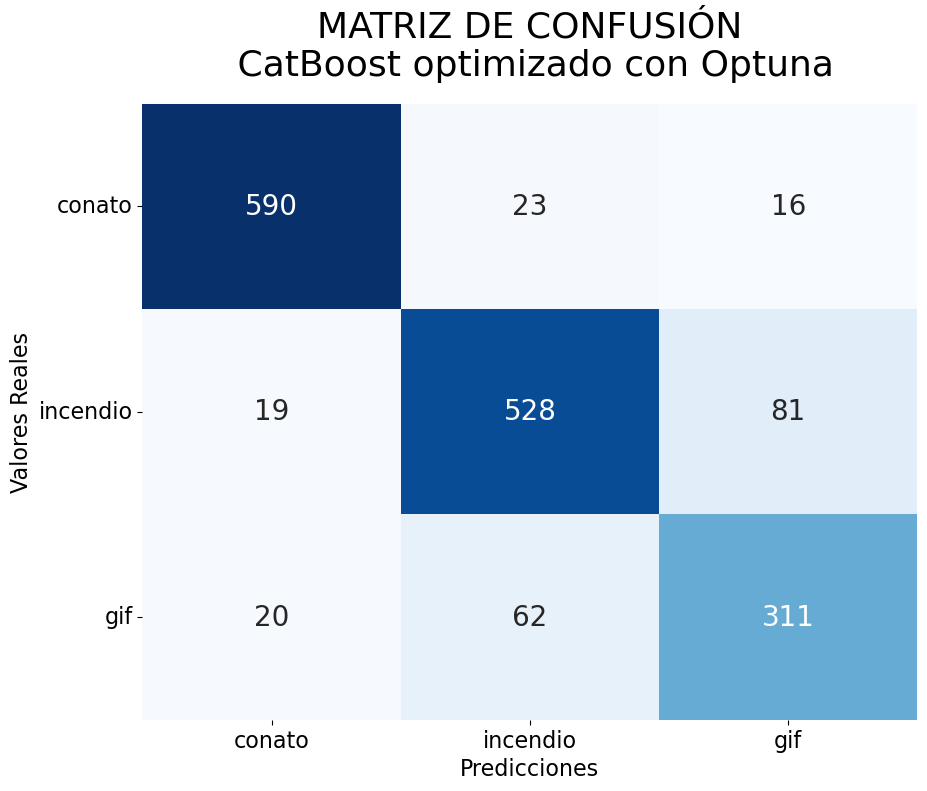

In [28]:
cm = confusion_matrix(y_test, y_pred_final, labels=[0, 1, 2])

# Etiquetas de las clases
etiquetas = ['conato', 'incendio', 'gif']

plt.figure(figsize=(10, 8))

# Creamos y mostramos la matriz
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=etiquetas, yticklabels=etiquetas,
            annot_kws={"size": 20},cbar=False)

plt.title("MATRIZ DE CONFUSIÓN\n CatBoost optimizado con Optuna", fontsize=26, pad=20)
plt.xlabel("Predicciones", fontsize=16)
plt.ylabel("Valores Reales", fontsize=16)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(rotation=0, fontsize=16)

# Mostramos la gráfica
plt.show()

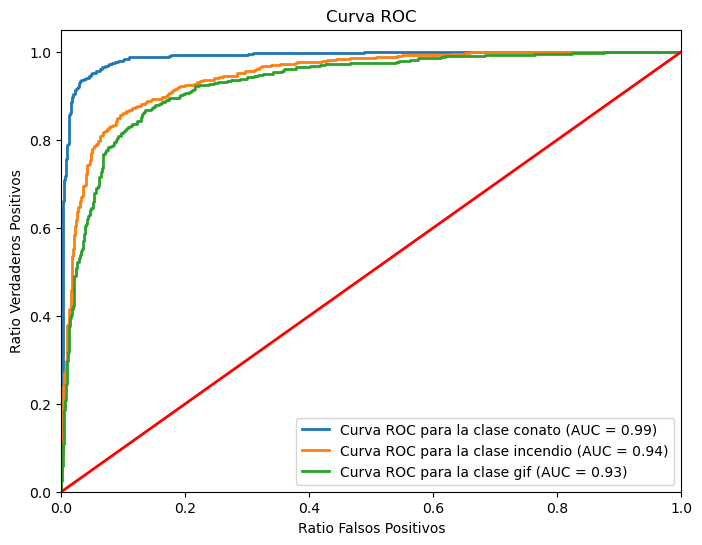

In [29]:
y_pred_prob = best_model.predict_proba(X_test)

# Diccionario para asignar nombres a las clases
class_names = {0: 'conato', 1: 'incendio', 2: 'gif'}

# Binarizamos porque es una clasificación multiclase
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Inicializamos las variables para calcular la curva ROC y el AUC
fpr = {}
tpr = {}
roc_auc = {}

# Dibujamos una curva ROC por cada clase y el cálculo del AUC
for i in range(3):  
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i])  

# Dibujar las curvas 
plt.figure(figsize=(8, 6))
for i in range(3):
    # Usamos el nombre de la clase en lugar del índice
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Curva ROC para la clase {class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Creamos la diagonal
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='-')

# Configurar el gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ratio Falsos Positivos')
plt.ylabel('Ratio Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')

# Mostrar el gráfico
plt.show()

In [15]:
import joblib

# Cargar el modelo desde el archivo .pkl
best_model = joblib.load('best_CatBoost_model.pkl')

# Verificar si se cargó correctamente (opcional)
print("Modelo cargado correctamente:", best_model)

Modelo cargado correctamente: <catboost.core.CatBoostClassifier object at 0x0000029600099760>


@inproceedings{akiba2019optuna,
  title={{O}ptuna: A Next-Generation Hyperparameter Optimization Framework},
  author={Akiba, Takuya and Sano, Shotaro and Yanase, Toshihiko and Ohta, Takeru and Koyama, Masanori},
  booktitle={The 25th ACM SIGKDD International Conference on Knowledge Discovery \& Data Mining},
  pages={2623--2631},
  year={2019}
}

#### Fuentes de datos:

1. **AEMET**: Los datos utilizados en este análisis provienen de la **Agencia Estatal de Meteorología (AEMET)**. Los datos están sujetos a las [condiciones de uso de AEMET](https://www.aemet.es/es/portada), y deben ser utilizados con la debida citación.
2. **EGIF**: Los datos utilizados en este análisis provienen de la **Estadística General de Incendios Forestales (EGIF)**, gestionada por el **Ministerio para la Transición Ecológica y el Reto Demográfico (MITECO)**. Los datos deben ser utilizados de acuerdo con las [condiciones de uso de la EGIF](https://www.miteco.gob.es/es/biodiversidad/temas/incendios-forestales/estadisticas-datos.aspx).
3. **NGMEP (Nomenclátor Geográfico de Municipios y Entidades de Población)**: Los datos utilizados en este análisis provienen del **Nomenclátor Geográfico de Municipios y Entidades de Población (NGMEP)**, proporcionado por el **Centro Nacional de Información Geográfica (CNIG)**. Los datos están sujetos a la licencia de [Datos Abiertos del CNIG](https://astronoomia.ign.es/web/ign/portal). Se debe proporcionar citación adecuada al utilizar los datos.
4. **Climate Data Store (CDS)**: Los datos utilizados en este análisis provienen del **Climate Data Store (CDS)**, específicamente del indicador de peligro de incendio **FWI** derivado de proyecciones climáticas para Europa. Los datos están sujetos a la [licencia de uso de CDS](https://cds.climate.copernicus.eu/#!/home), y deben ser utilizados con la debida citación.
5. **INE (Instituto Nacional de Estadística)**: Los datos utilizados en este análisis provienen de las **Series de población por provincia (1900-2001)**, las **principales series de población desde 1998** y del **Código INE**. Los datos están sujetos a las [condiciones de uso del INE](https://www.ine.es/jaxiT3/Datos.htm?t=2865), y deben ser utilizados con la debida citación.